#### Customer sentiment analaysis

In [1]:
# Importing librairies
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

##### Loading the dataset

In [2]:
# Link to the dataset
data_link='https://raw.githubusercontent.com/kueyram/Customer-sentiment-analysis/refs/heads/main/data/restaurant_reviews.csv'

# Importing the dataset into pandas
reviews_data = pd.read_csv(data_link, sep=',')

# Checking the shape of the dataset
reviews_data.shape

(10000, 8)

In [3]:
# Printing random rows from the dataset
reviews_data.sample(n=5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
1655,NorFest - The Dhaba,Rubin S Cherian,"This has been on my list for a while now, but ...",4,"62 Reviews , 516 Followers",9/12/2018 15:09,0,NaN
5733,Being Hungry,Niranjan Reddy,Good Taste,4,"3 Reviews , 1 Follower",9/8/2018 1:59,0,NaN
9067,Arena Eleven,George B.,Experience at Arena Eleven... Since it’s in SL...,3,"173 Reviews , 345 Followers",3/22/2019 23:43,8,NaN
6782,Yum Yum Tree - The Arabian Food Court,K Rajesh,food was really worst taste.,1,"2 Reviews , 1 Follower",7/15/2018 14:45,0,NaN
5890,Tempteys,Praveen,Good,4,2 Reviews,6/26/2018 21:51,0,NaN


In [4]:
# List of columns
reviews_data.columns

Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures', '7514'],
      dtype='object')

###### Cleaning the dataset

In [5]:
# Dropping not needed columns
reviews_data = reviews_data.drop(columns = ['Reviewer', 'Metadata', 'Time', 'Pictures', 'Restaurant','7514'])

# Printing the 5 first rows
reviews_data.head(5)

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


In [6]:
# Function to clean the dataset
# We are going to remove special characters, whitespaces, stopwors and convert to lowercase

def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Removing non-word characters
    text = re.sub(r'\s+', ' ', text)  # Removing extra spaces
    text = text.lower()  # Converting to lowercase
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)


# Lets apply the cleaning function to the review columns
reviews_data['cleaned_review'] = reviews_data['Review'].apply(clean_text)

##### Target and features

In [7]:
# Let's convert rating to numeric
reviews_data['Rating'] = pd.to_numeric(reviews_data['Rating'], errors='coerce')

# Positive and negative
reviews_data['sentiment'] = np.where(reviews_data['Rating'] >= 4, 1, 0)  # 1 = Positive, 0 = Negative

In [8]:
# Features and labels
features = reviews_data['cleaned_review']
labels = reviews_data['sentiment']

In [9]:
# Splitting the dataset
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
# Data transformation
# Text data will be transformed into numerical features using TF-IDF
tfidf = TfidfVectorizer()
features_train_tfidf = tfidf.fit_transform(features_train)
features_test_tfidf = tfidf.transform(features_test)

##### Logistic regression

In [11]:
# Building a simple logistic regression model
model = LogisticRegression()
model.fit(features_train_tfidf, labels_train)

LogisticRegression()

In [12]:
# Making predictions on the test data
labels_pred = model.predict(features_test_tfidf)

In [13]:
# Evaluating the model
accuracy = accuracy_score(labels_test, labels_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(labels_test, labels_pred))

Accuracy: 0.8860
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       736
           1       0.89      0.94      0.91      1264

    accuracy                           0.89      2000
   macro avg       0.89      0.87      0.87      2000
weighted avg       0.89      0.89      0.88      2000



In [14]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(labels_test, labels_pred)

# Printing the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 586  150]
 [  78 1186]]


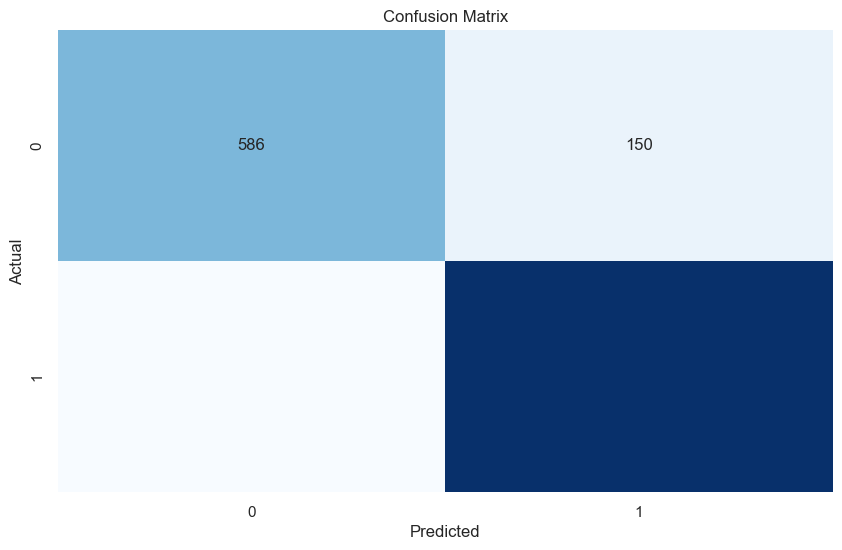

In [15]:
# Visualizing the confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(confusion_matrix(labels_test, labels_pred)), annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
# Function to predict sentiment of a new review
def predict_sentiment(review_text):
    cleaned_review = clean_text(review_text)
    review_tfidf = tfidf.transform([cleaned_review])
    prediction = model.predict(review_tfidf)
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    return sentiment

In [17]:
# Testing the function
new_review1 = "The food was amazing, and the service was excellent. Highly recommend!"
print(f"Sentiment: {predict_sentiment(new_review1)}")

Sentiment: Positive


In [18]:
new_review2 = "The food was horrible. I was so disappointed"
print(f"Sentiment: {predict_sentiment(new_review2)}")

Sentiment: Negative


##### Let's create a web interface using streamlit

In [ ]:
# Setting up the Streamlit interface
st.title("Customer Sentiment Analysis of Restaurant Reviews")
st.write(
    "Enter a restaurant review to get a sentiment prediction (Positive/Negative)."
)

# Input field for the review
review_text = st.text_area("Enter the Review:")

# Button to trigger the prediction
if st.button("Predict Sentiment"):
    if review_text:
        result = predict_sentiment(review_text)
        st.write(f"The sentiment of the review is: **{result}**")
    else:
        st.write("Please enter a review.")